In [ ]:
##ONLY IF NO PACKAGES ARE NOT INSTALLED... YOUR WELCOME BBY <3
# !pip install simpleitk
# !pip install numpy
# !pip install pynrrd
# !pip install opencv-python

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import os as os
import nrrd as reader
#from sklearn.preprocessing import Normalizer
import cv2  
from skimage import morphology
from skimage.measure import label
from skimage.segmentation import active_contour
from skimage import data, io, img_as_ubyte,filters

j = 5

In [5]:
# Image Import

In [6]:
def join(one, two):
    return os.path.join(one, two)

In [7]:
def check_path(path):
    count=0
    for files in sorted(os.listdir(path)):
        image_path = os.path.join(path,files)
        count+=1
    return count

In [8]:
# (patient count* 15) check_path function will return total patient count 
folder_path = join(os.getcwd(), "dataset")
test_path = join(os.getcwd(),"Test")
length = check_path(folder_path)
inputs = np.zeros((length*15,256,256, 1))
outputs = np.zeros((length*15,256,256 , 9))


In [9]:
#Inhomogeneity Correction
def correct_roi(image):
    inputImage=sitk.GetImageFromArray(image)
    inputImage = sitk.Cast(inputImage, sitk.sitkFloat32 )
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    output = corrector.Execute( inputImage)
    image_c= sitk.GetArrayFromImage(output)
    image_c=cv2.normalize(src=image_c, dst=None, alpha=0.0, beta=255.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) #need to normalize, not direct conversion by "np.uint8"
    return image_c

In [22]:
def dcm_to_np(path):
    global dic_count
    try:
        slice_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(path)
        image = sitk.ReadImage(slice_filenames)
        for x in range(15):
            current_slice = image[:, :, x]
            current_array = sitk.GetArrayFromImage(current_slice)
            split_array = current_array[:,:-256]
            inputs[dic_count] = split_array[:, :, np.newaxis]
            dic_count+=1
        print(dic_count)
    except Exception as e:
        print(e)
#         print("Problem with this folder -> " + path)

In [48]:
def nrrd_to_np(meta_object,path,outputs):
    global ann_count
    try:
        current_seg = data[slice_count, :, :]
        half_seg = current_seg[:,:-256]
        black = np.zeros([256, 256, 9])
        for y, a in enumerate(half_seg):
            for x, b in enumerate(a):
                if b>0:
                    black[y][x][b-1] = 1
        return black
        ann_count+=1
        print(ann_count)
    except Exception as e:
        print(e)

In [1]:
def fle_to_np(meta_object,path,outputs):
    global ann_count
    try:
        data = sitk.GetArrayFromImage(meta_object)
        for p in range(15):
            outputs[ann_count] = np.expand_dims(np.where(data[p, :, :256] == 1, 1, 0), axis=2)
            ann_count+=1
        print(ann_count)
    except Exception as e:
        print(e)
        print(path)

In [2]:
mskoutputs = np.zeros((length*15,256,256 , 9))
dic_count = 0
ann_count = 0
try:
    for patient in sorted(os.listdir(folder_path)):
        
        patient_path = join(folder_path, patient)
        nrrd_folder = join(patient_path, "NRRD")
        dcm_to_np(patient_path)
        for nrrd in os.listdir(nrrd_folder):
            if(".nrrd" in nrrd):
                segmentation = sitk.ReadImage(join(nrrd_folder, nrrd))
                nrrd_to_np(segmentation,nrrd,mskoutputs)
        print(patient)
except Exception as e:
    print(e)

NameError: name 'np' is not defined

In [3]:
fleoutputs=np.zeros((length*15,256,256 , 1))
dic_count = 0
ann_count = 0
try:
    for patient in sorted(os.listdir(folder_path)):
        patient_path = join(folder_path, patient)
        fle_folder = join(patient_path, "FLE")
        for fle in os.listdir(fle_folder):
            if(".nrrd" in fle):
                flesegmentation = sitk.ReadImage(join(fle_folder, fle))
                fle_to_np(flesegmentation,fle,fleoutputs)
                 
except Exception as e:
    print(e)

NameError: name 'np' is not defined

In [1]:
#opencv + numpy normalization 
for x in range (j):    
    temp = inputs[x].reshape(256, 256)
    temp1= correct_roi(temp)
    np.linalg.norm(temp1)
    inputs[x]=temp1[:, :, np.newaxis]
    print(x)

NameError: name 'j' is not defined

In [ ]:
# Image Processing

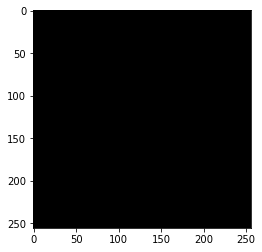

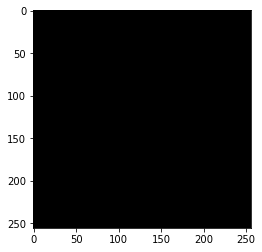

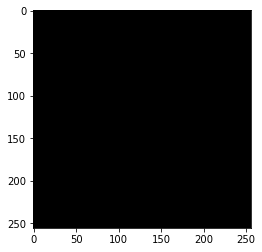

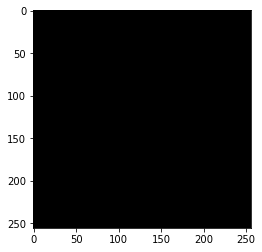

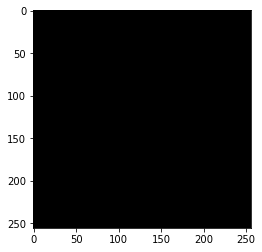

In [51]:
#Merging all 9 channels of masks into 1 channel
merged_array = np.zeros((length*15,256,256 , 1))
for x in range (j):
    for i in range (9):
        if i !=2:
            merged_array[x,:,:,0]+=mskoutputs[x,:,:,i]
#Removal of 4th dimension     
merged_array1=merged_array[:, :, :, 0]
inputs1=inputs[:, :, :, 0]

#Subcutaneous Fat Mask
invmask=1-merged_array1
invroi=invmask*inputs1
#Removal of Background Noise
roi=merged_array1*inputs1

for i in range (j):
    plt.imshow(roi[i],cmap=plt.cm.bone)
    plt.show()

In [ ]:
for i in range (2):
    plt.imshow(outputs[i])
    plt.show()